In [1]:
#%% Importing modules and data
import smtplib
import pandas as pd
import pandas.io.data as web
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

start = dt.datetime(1993, 1, 1)
end = dt.datetime.today() #dt.datetime.now()

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
# Importing Data
# Function for importing data
def tick_data(ticker_list, out_columns = ['Adj Close']):
    df_list = []
    for ticker in ticker_list:
        curr_df = web.DataReader(ticker, 'yahoo', start, end)[out_columns]
        tickname = ticker + '_{0}'
        curr_df.columns = [tickname.format(header) for header in curr_df.columns.tolist()]
        df_list = df_list + [curr_df]
    return df_list
        
tick_lst = ['VXX','UVXY','^GSPC','^VIX','JNUG','TLT']
dflst = tick_data(tick_lst)

In [3]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0])
    axes[0,0].xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),interval=1))
    axes[0,0].xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    axes[0,0].xaxis.set_major_locator(dates.MonthLocator())
    axes[0,0].xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    
    df.tail(plot_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(plot_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(plot_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    return df

In [4]:
def vol_summary(adj_c_df,rolling_period,lookback_window):
    etf = price_devs(adj_c_df,rolling_period,lookback_window)
    
    # Describing Deviation Data
    obs = lookback_window

    print(etf.price_dev.tail(obs).describe(percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 20, (-10,10))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 20, (-10,10))[0]}
    df = pd.DataFrame(d)
    print(df)
    return df

--------------------------------
VXX
--------------------------------


C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean      -0.124900
std        1.223888
min       -4.658000
10%       -1.249842
20%       -0.859000
30.0%     -0.625070
40%       -0.401584
50%       -0.204491
60%       -0.082807
70%        0.137837
80%        0.428434
90%        1.036614
max        9.393439
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-4.65800006365
2016-11-07 00:00:00
---------------------
Date of largest spike
9.39343859361
2016-09-09 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           0      -9.0
2           0      -8.0
3           0      -7.0
4           0      -6.0
5           1      -5.0
6           0      -4.0
7           5      -3.0
8          32      -2.0
9         122      -1.0
10         63       0.0
11         21       1.0
12          3       2.0
13          2       3.0
14          2       4.0
15          0       5.0
16          0       6.0
17          0       7.0
18          0       8.0
19          1       9.0
------

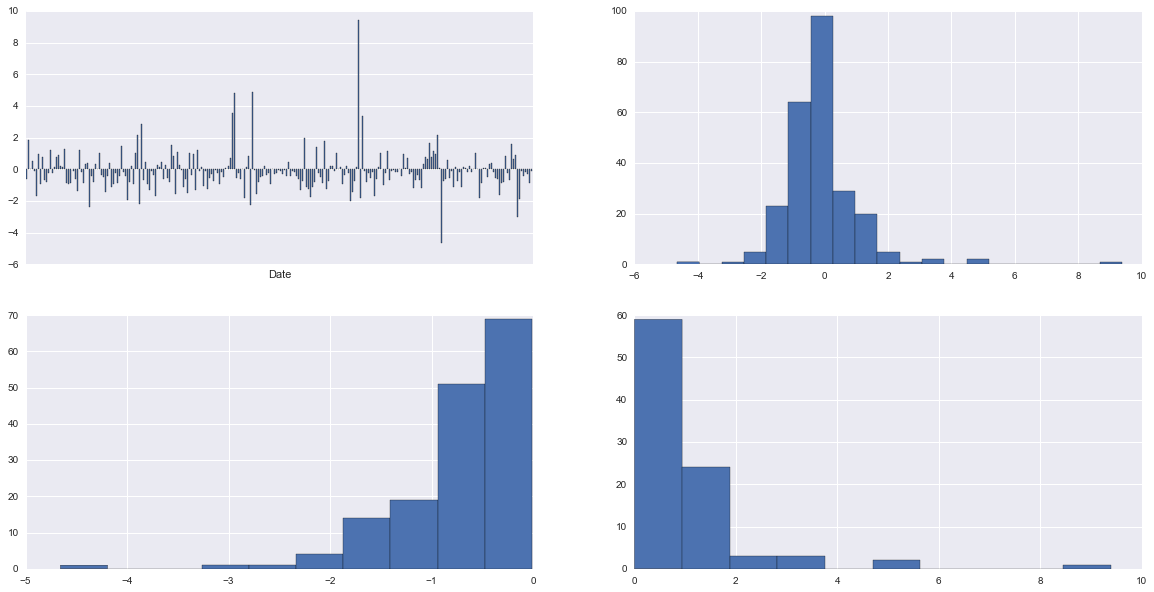

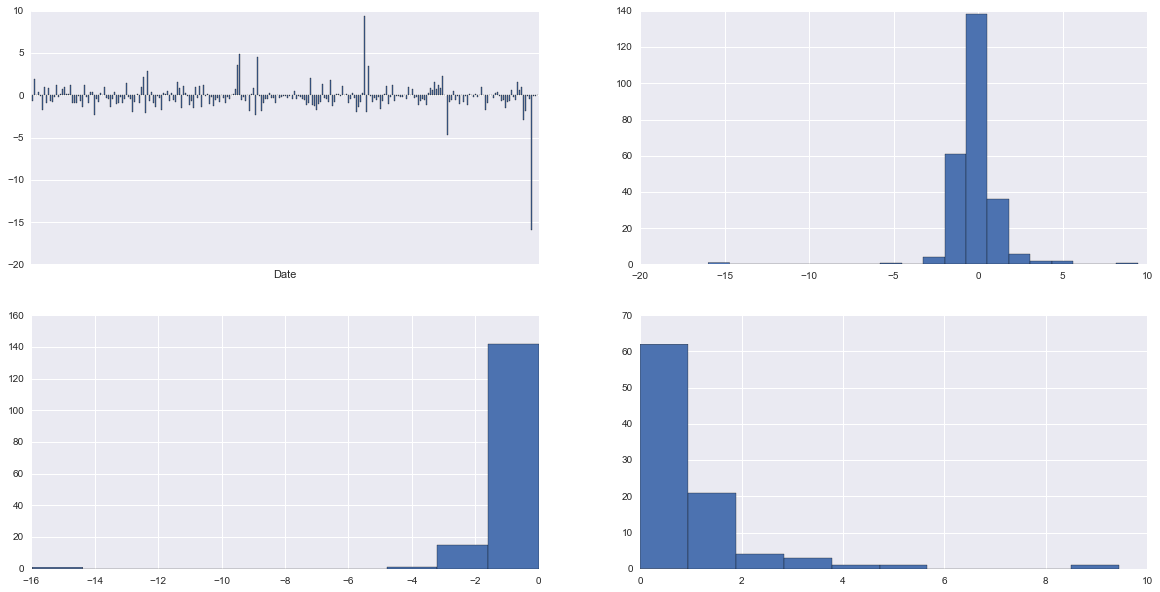

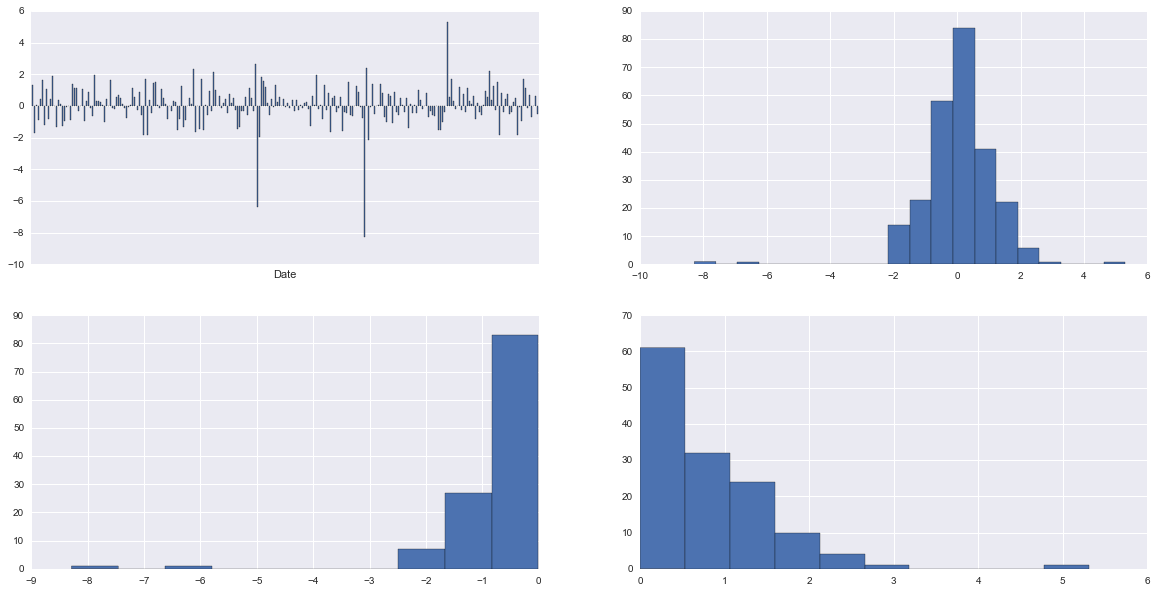

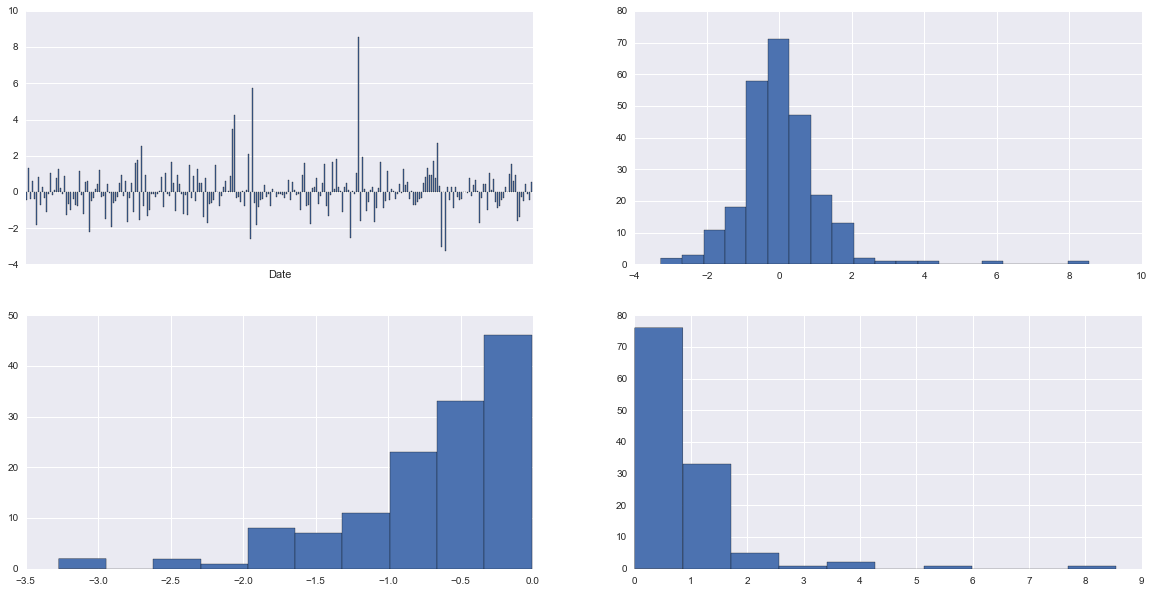

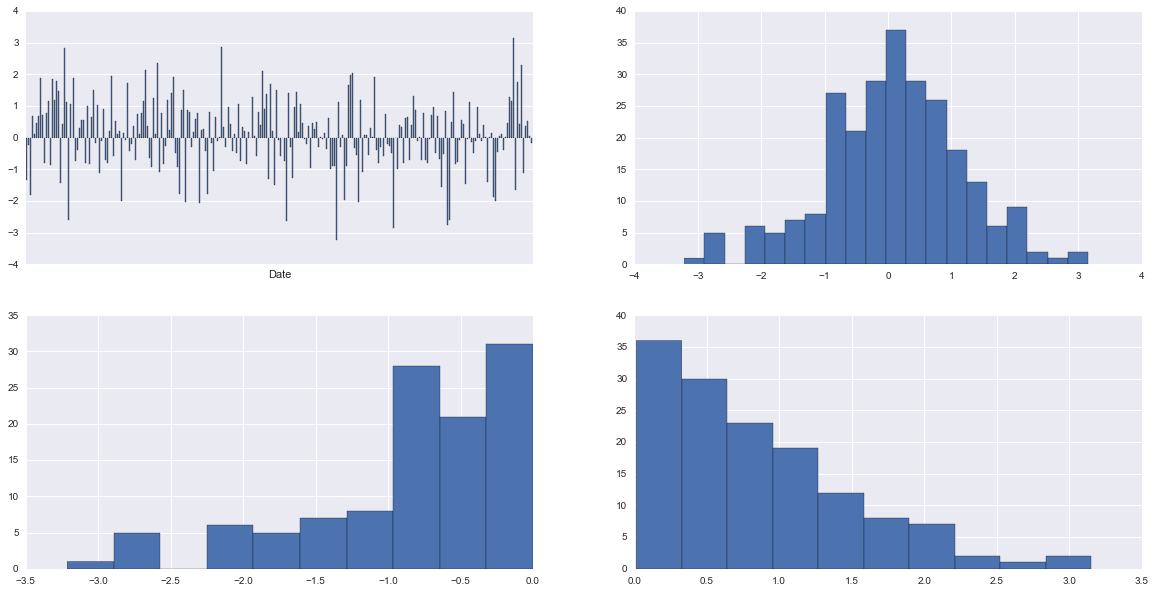

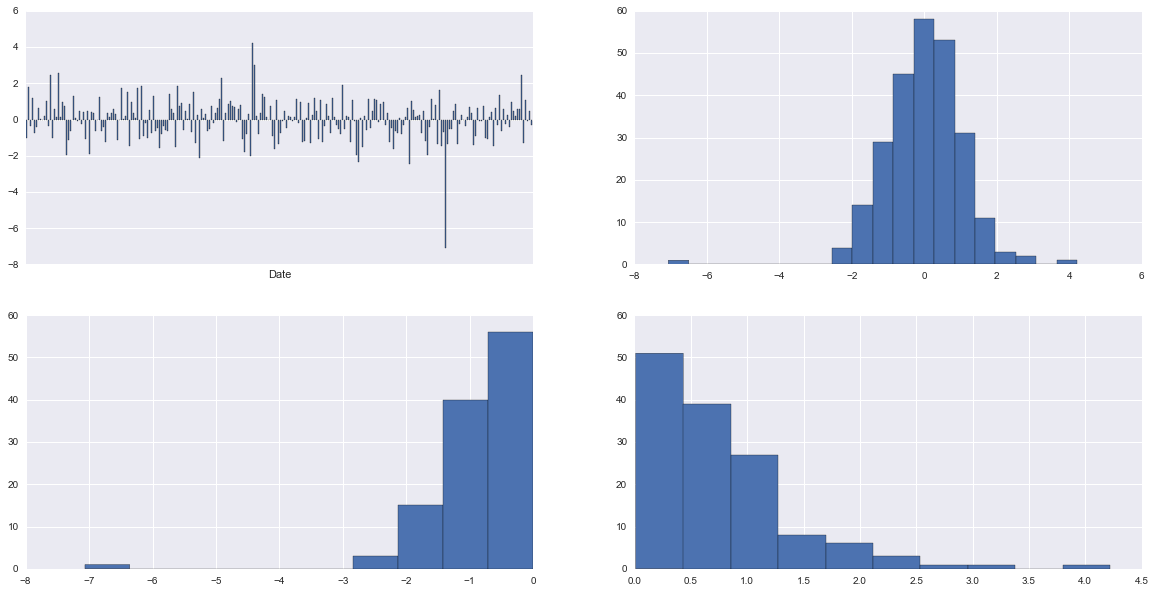

In [5]:
# Summaries
i = 0
hist_lst = []
rolling_p = 22
lookback = 252
for df in dflst:
    etf_name = tick_lst[i]
    print('--------------------------------')
    print(etf_name)
    print('--------------------------------')
    curr_df = vol_summary(df,rolling_p,lookback)
    curr_df.columns = [etf_name + 'Frequency',etf_name + 'Std Bins']
    hist_lst = hist_lst + [curr_df]
    i = i+1
    

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean      -0.124900
std        1.223888
min       -4.658000
10%       -1.249842
20%       -0.859000
30.0%     -0.625070
40%       -0.401584
50%       -0.204491
60%       -0.082807
70%        0.137837
80%        0.428434
90%        1.036614
max        9.393439
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-4.65800006365
2016-11-07 00:00:00
---------------------
Date of largest spike
9.39343859361
2016-09-09 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           0      -9.0
2           0      -8.0
3           0      -7.0
4           0      -6.0
5           1      -5.0
6           0      -4.0
7           5      -3.0
8          32      -2.0
9         122      -1.0
10         63       0.0
11         21       1.0
12          3       2.0
13          2       3.0
14          2       4.0
15          0       5.0
16          0       6.0
17          0       7.0
18          0       8.0
19          1       9.0


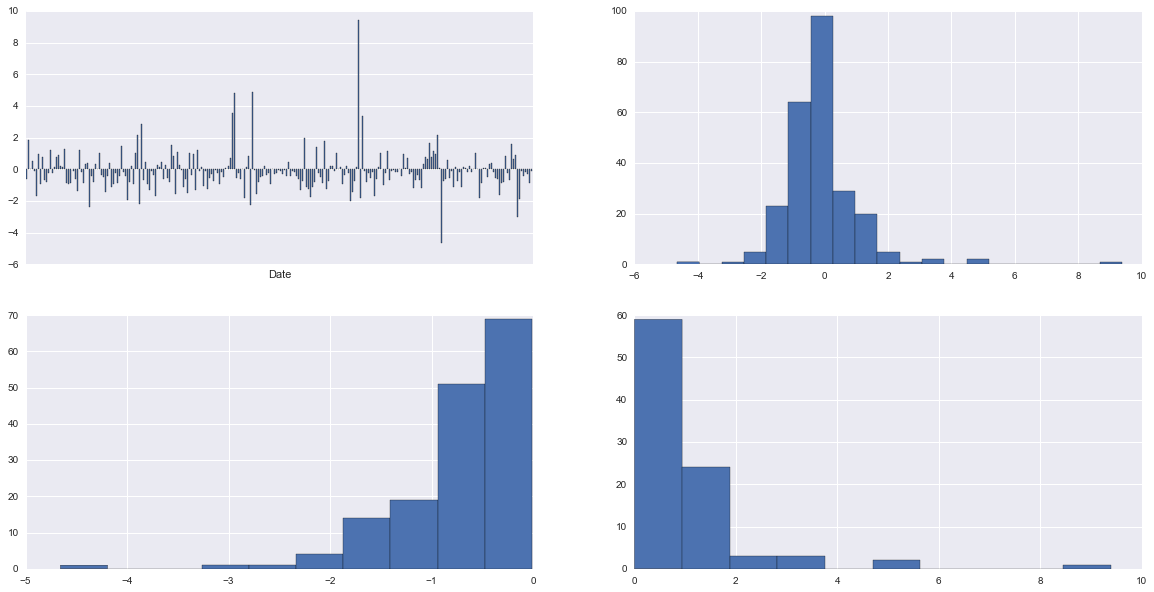

In [6]:
vxx = vol_summary(dflst[0],22,252)

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean      -0.186207
std        1.578934
min      -15.974126
10%       -1.271359
20%       -0.864557
30.0%     -0.655100
40%       -0.414775
50%       -0.185877
60%       -0.058413
70%        0.134271
80%        0.418021
90%        1.050191
max        9.442860
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-15.9741255308
2017-01-09 00:00:00
---------------------
Date of largest spike
9.44286030928
2016-09-09 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           0      -9.0
2           0      -8.0
3           0      -7.0
4           0      -6.0
5           1      -5.0
6           0      -4.0
7           4      -3.0
8          33      -2.0
9         120      -1.0
10         65       0.0
11         19       1.0
12          4       2.0
13          2       3.0
14          2       4.0
15          0       5.0
16          0       6.0
17          0       7.0
18          0       8.0
19          1       9.0


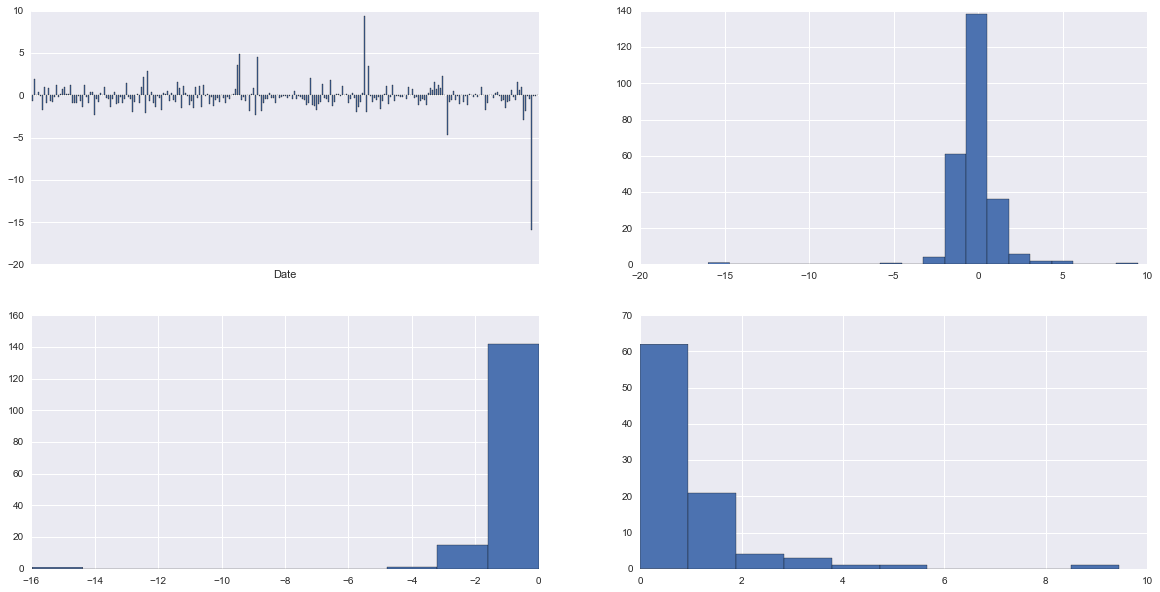

In [7]:
uvxy = vol_summary(dflst[1],22,252)

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean       0.064406
std        1.166699
min       -8.287612
10%       -1.072633
20%       -0.581755
30.0%     -0.322248
40%       -0.092831
50%        0.031681
60%        0.275437
70%        0.507812
80%        0.805116
90%        1.310511
max        5.311020
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-8.28761216015
2016-09-09 00:00:00
---------------------
Date of largest spike
5.31101967175
2016-11-07 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           1      -9.0
2           0      -8.0
3           1      -7.0
4           0      -6.0
5           0      -5.0
6           0      -4.0
7           1      -3.0
8          25      -2.0
9          91      -1.0
10         91       0.0
11         36       1.0
12          5       2.0
13          0       3.0
14          0       4.0
15          1       5.0
16          0       6.0
17          0       7.0
18          0       8.0
19          0       9.0


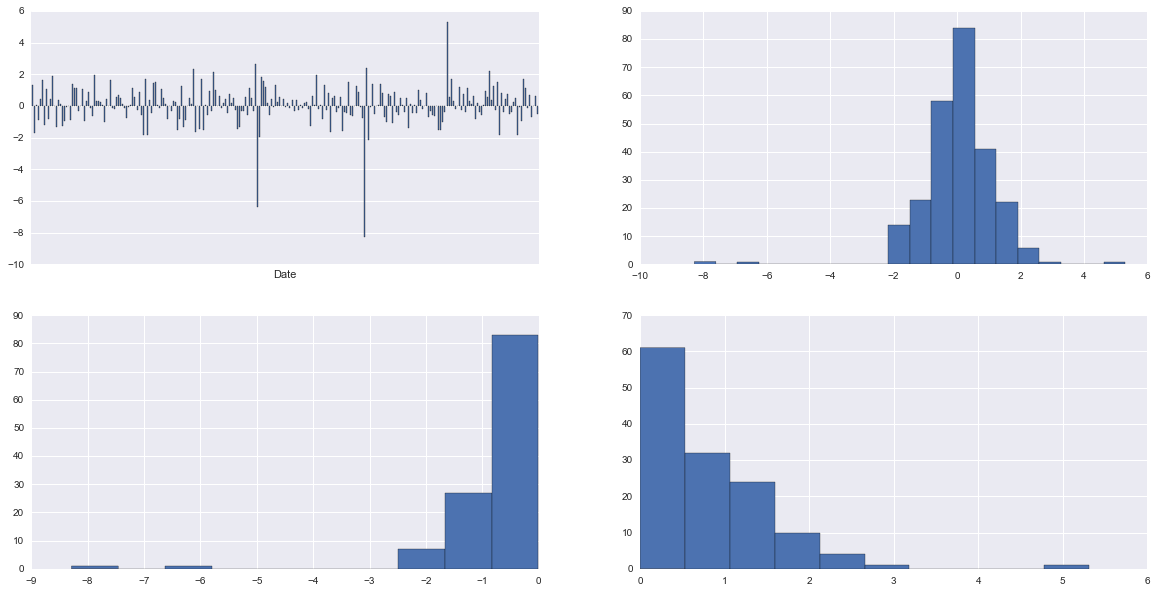

In [8]:
spx = vol_summary(dflst[2],22,252)

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean       0.035830
std        1.177859
min       -3.271760
10%       -1.097872
20%       -0.710190
30.0%     -0.425460
40%       -0.262871
50%       -0.104538
60%        0.118401
70%        0.430257
80%        0.744024
90%        1.186862
max        8.546470
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-3.27176019625
2016-11-09 00:00:00
---------------------
Date of largest spike
8.54646956442
2016-09-09 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           0      -9.0
2           0      -8.0
3           0      -7.0
4           0      -6.0
5           0      -5.0
6           2      -4.0
7           3      -3.0
8          26      -2.0
9         102      -1.0
10         87       0.0
11         25       1.0
12          3       2.0
13          1       3.0
14          1       4.0
15          1       5.0
16          0       6.0
17          0       7.0
18          1       8.0
19          0       9.0


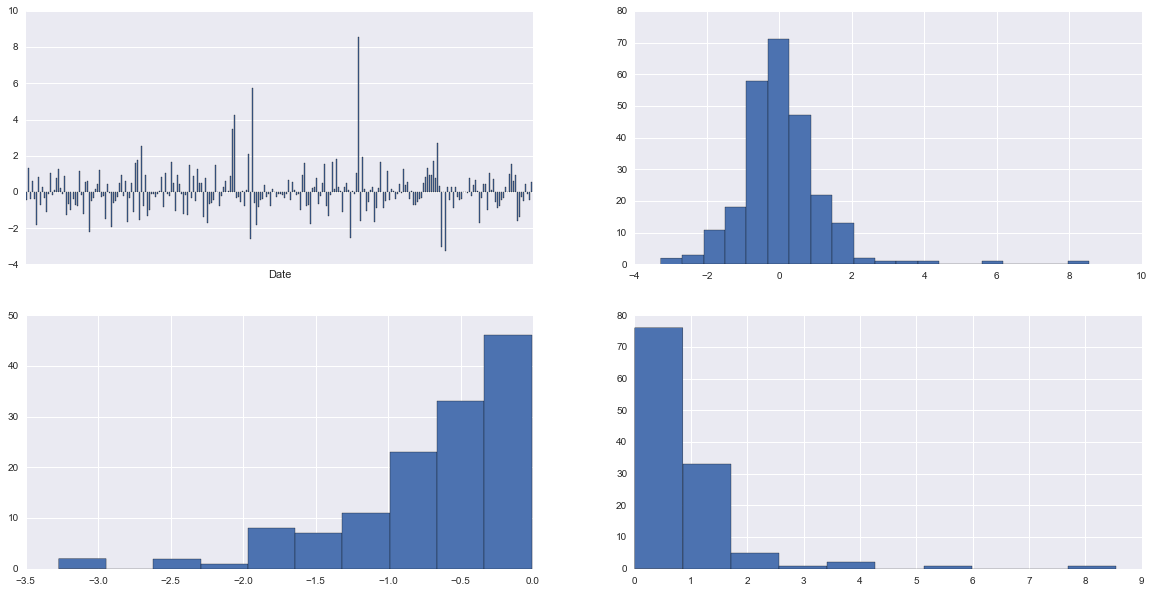

In [9]:
vix = vol_summary(dflst[3],22,252)

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean       0.088677
std        1.075997
min       -3.213645
10%       -1.112566
20%       -0.744528
30.0%     -0.414315
40%       -0.101530
50%        0.102486
60%        0.360810
70%        0.622056
80%        0.955926
90%        1.425608
max        3.151319
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-3.21364503222
2016-08-24 00:00:00
---------------------
Date of largest spike
3.15131870727
2016-12-29 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           0      -9.0
2           0      -8.0
3           0      -7.0
4           0      -6.0
5           0      -5.0
6           1      -4.0
7           9      -3.0
8          21      -2.0
9          81      -1.0
10         94       0.0
11         38       1.0
12          7       2.0
13          1       3.0
14          0       4.0
15          0       5.0
16          0       6.0
17          0       7.0
18          0       8.0
19          0       9.0


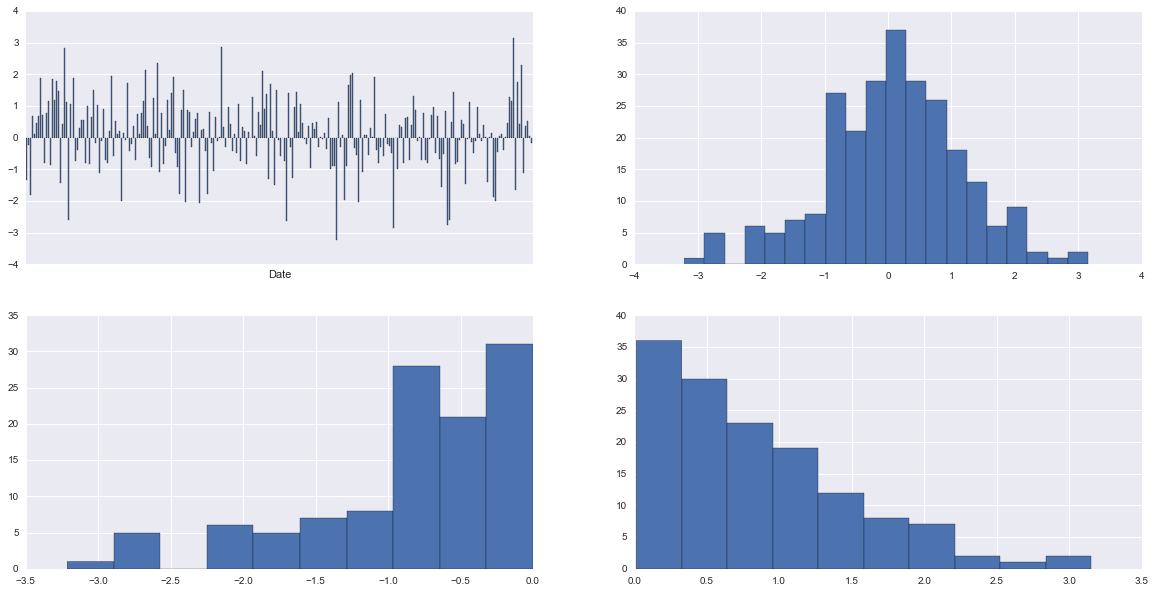

In [10]:
jnug = vol_summary(dflst[4],22,252)

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).std(ddof=1)
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


count    252.000000
mean       0.004397
std        1.092595
min       -7.065354
10%       -1.272878
20%       -0.808533
30.0%     -0.510236
40%       -0.162478
50%        0.116620
60%        0.279554
70%        0.485926
80%        0.786795
90%        1.145447
max        4.220795
Name: price_dev, dtype: float64
---------------------
Date of largest drop
-7.06535436425
2016-11-09 00:00:00
---------------------
Date of largest spike
4.22079461646
2016-06-24 00:00:00
---------------------
    Frequency  Std Bins
0           0     -10.0
1           0      -9.0
2           1      -8.0
3           0      -7.0
4           0      -6.0
5           0      -5.0
6           0      -4.0
7           3      -3.0
8          41      -2.0
9          70      -1.0
10        100       0.0
11         31       1.0
12          4       2.0
13          1       3.0
14          1       4.0
15          0       5.0
16          0       6.0
17          0       7.0
18          0       8.0
19          0       9.0


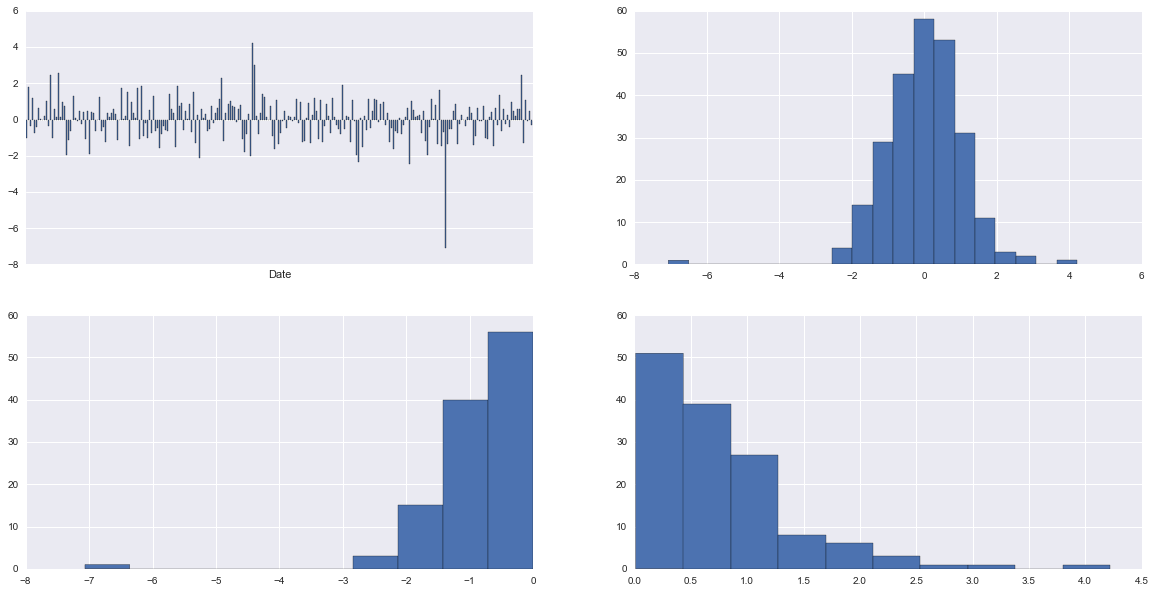

In [11]:
tlt = vol_summary(dflst[5],22,252)